### Preamble

This notebook contains work on a [kaggle competition](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings) sponsored by AirBnB and aimed at predicting in which country a new user will make their first booking in. This competition was run for recruitment purposes a few years ago and provides a very nice example of a real-life data science challenge.

### Imports and helpers

In [34]:
# General
from pathlib import Path
import os
from functools import partial
import matplotlib.pyplot as plt

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#plt.rcParams['figure.figsize'] = (15, 5)



%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import datetime

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
from pandas.api.types import is_string_dtype

def make_categorical(df):
    
    categories = {}

    for c in df.columns:

        if is_string_dtype(df[c]):
            df[c] = df[c].astype("category").cat.as_ordered()
            categories[c] = df[c].cat.categories
            df[c] = df[c].cat.codes
            
    return df, categories

In [5]:
def apply_categories(df, categories):
    
    for c in df.columns:
        
        if is_string_dtype(df[c]):
            df[c] = pd.Categorical(df[c], categories=categories, ordered=True)
            df[c] = df[c].cat.codes

This implementation of the evaluation metric described on the [competition homepage](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings#evaluation) is based on work shared in the [competition discussion](https://www.kaggle.com/wendykan/ndcg-example).

In [6]:
def dcg_at_k(r, k, method=1):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError("method must be 0 or 1.")
    return 0.


def ndcg_at_k(r, k, method=1):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [7]:
def format_preds_wd(m, X, index_col=False):
    """ Get top five class codes in wide format ordered by probability from left to right
    m : A fitted sklearn model implementing predict_proba
    X : Feature matrix
    """
    
    probs = m.predict_proba(X)
    res = pd.DataFrame(probs.argsort()[:, -5:][:, ::-1])
    if index_col:
        res["id"] = X.index
    else:
        res = res.set_index(X.index)
    return res

In [8]:
def format_preds_lng(m, X, mapper=None):
    res = pd.melt(format_preds_wd(m, X, index_col=True), id_vars="id", value_name="country").sort_values(by=["id", "variable"]).drop("variable", axis=1)
    if mapper: res.country = res.country.map(mapper)
    return res

In [9]:
def score_predictions_wd(preds, y_true, k=5):
    """
    preds: pd.DataFrame
      one row for each observation, one column for each prediction.
      Columns are sorted from left to right descending in order of likelihood.
    truth: pd.Series
      one row for each observation.
    """
    assert(len(preds)==len(y_true))
    r = pd.DataFrame(0, index=preds.index, columns=preds.columns, dtype=np.float64)
    for col in preds.columns:
        r[col] = (preds[col] == y_true) * 1.0

    score = pd.Series(r.apply(partial(ndcg_at_k, k=k), axis=1, result_type="reduce"), name="score")
    print(f"Average NDCG at {k}: {score.mean():.4f}")
    return score

### Data preprocessing

#### Read in the available data and check out what we have

##### Users

The `users` table is the main data source we have. There is one entry for each unique user. We have data on a total of `213.451 users` available for training. The test set contains `62.096` rows.  The users table provides basic information for each user as well as the target for our prediction task, the `country_destination` column.

Our target has 12 possible values: `'NDF', 'US', 'other', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL', 'DE', 'AU'`.

Among these, there are two special values:

- `NDF` - no destination found, i.e. no booking took place yet
- `other` - the user booked, but not in one of the 10 main countries

In [10]:
# define the path to the folder data
DATA_PATH = Path.cwd() / "data"

In [27]:
# load the train dataset
train_users = pd.read_csv(DATA_PATH / "train_users_2.csv")

In [12]:
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [13]:
train_users.shape

(213451, 16)

In [14]:
null_columns = train_users.columns[train_users.isnull().any()]
print(train_users[null_columns].isnull().sum())

date_first_booking         124543
age                         87990
first_affiliate_tracked      6065
dtype: int64


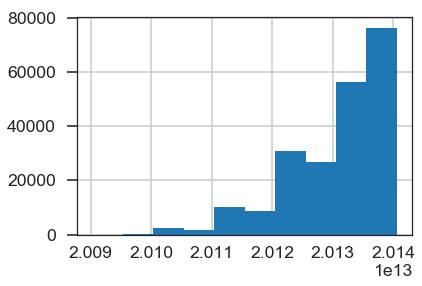

In [15]:
train_users['timestamp_first_active'].hist(bins=10)

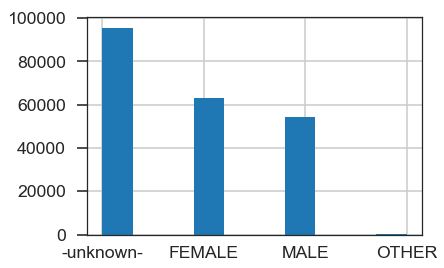

In [16]:
train_users.gender.hist()

In [17]:
train_users.groupby(['age','country_destination']).sum()

timestamp_first_active  signup_flow
age    country_destination                                     
1.0    NDF                          40271136071591           24
2.0    ES                           20130910134332            0
       NDF                          60401649643946           25
       US                           40261234205547            0
       other                        20110616193150            2
4.0    IT                           20100806065100            3
       NDF                          40201640245562            4
5.0    DE                           20100911155324            3
       FR                           40201217247859            5
       GB                           20100817002755            2
       IT                           20100429161617            0
       NDF                         723627854390117           79
       US                           80402690565964           10
15.0   NDF                         100673779672982           25
       US                           60380958368364            0
16.0   NDF                         503346766541434           87
       US                           20140524074410            0
17.0   GB                           20140521110218            0
       NDF                        1268422941397709          190
       US                           60381035240015            2
18.0   AU                           20120827100521           12
       CA                          221397823943879           10
       DE                          241497975254809           16
       ES                          140853592176770           29
       FR                          483015115586797           13
       GB                          221417146547439           26
       IT                          362288181783879           29
       NDF                        5978631436322363          730
       NL                          100652961894219            0
       US                         4689480734717955          425
...                                            ...          ...
1936.0 NDF                          20140504195714           25
       US                           20130824181551            0
1938.0 US                           20140531031949            0
1942.0 FR                           20140308072555           23
1947.0 US                           20140617230607            0
       other                        20140529072549           23
1949.0 NDF                          20140622214130            0
       US                           40261431247689           35
1952.0 NDF                          20131022053400            0
1953.0 NDF                          20140226225536           23
1995.0 NDF                          20140319204406           24
2008.0 US                           20140420214553           24
2013.0 FR                           20131014203034            0
       GB                           20131101215216            0
       NDF                         483014947700421           18
       NL                           20111214163000            0
       US                          221346968559814            5
       other                        20130502183255            0
2014.0 AU                           20130706185647            0
       CA                          120754413317868            0
       DE                          140843917895642           10
       ES                          181174410171398            0
       FR                          342091761921051           39
       GB                          181174744988808            3
       IT                          261725334743253           25
       NDF                        7406431511046695          299
       NL                           80521445394857            3
       PT                           20140112063455            0
       US                         4689475005063806          369
       other                       845248266123085          

In [18]:
print(train_users.age[train_users.age<18].count())
print(train_users.age[train_users.age>90].count())
print(train_users.age.isna().sum())

158
2543
87990


In [28]:
train_users.age[train_users.age>90]=np.nan

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
train_users.age[train_users.age<18]=np.nan

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
print(train_users.age[(train_users.age<18)&(train_users.age>0)].count())
print(train_users.age[train_users.age>90].count())
print(train_users.age.isna().sum())

0
0
90691


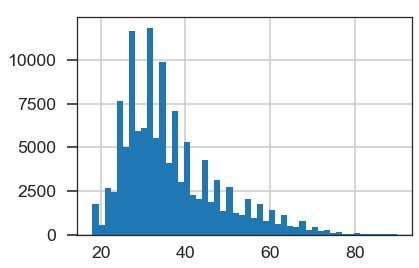

In [31]:
train_users.age.hist(bins=50)

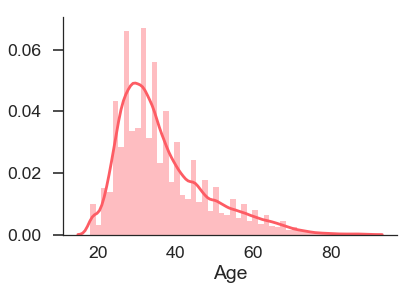

In [35]:
sns.distplot(train_users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()

In [23]:
train_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [41]:
train_users['date_account_created'] = pd.to_datetime(train_users['date_account_created']).dt.year

In [78]:
train_users['timestamp_first_active'] = pd.to_datetime(train_users['timestamp_first_active'], format='%Y%m%d%H%M%S').dt.year

In [45]:
len(train_users)

213451

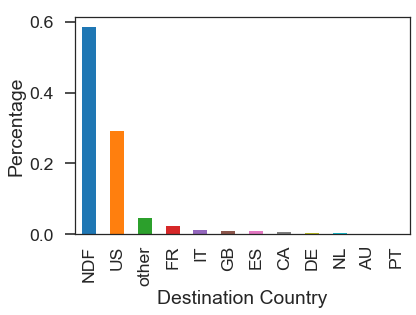

In [97]:
train_users.country_destination.value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
plt.savefig("destinationPercentage.png")

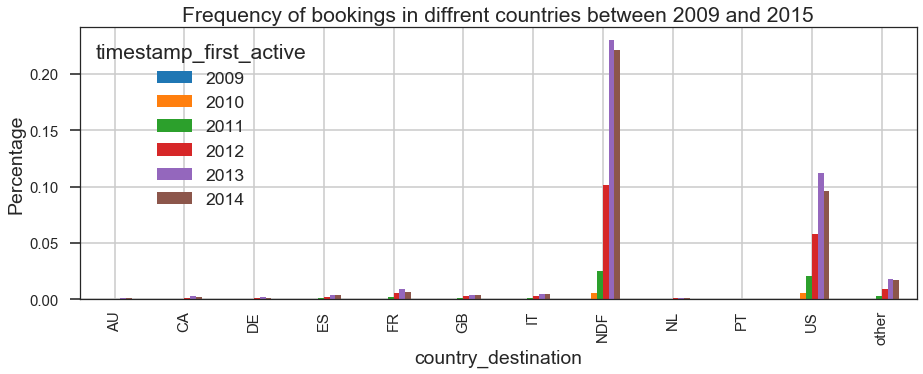

In [98]:
# plot data
ax = train_users.groupby(['country_destination','timestamp_first_active']).size().apply(lambda x: (x/len(train_users))).unstack().plot(kind='bar',fontsize=15, figsize=(15,5))
plt.ylabel('Percentage')
plt.title('Frequency of bookings in diffrent countries between 2009 and 2015')
plt.grid()
fig = ax.get_figure()
fig.savefig('bookingsFq.png')
# use unstack()


In [65]:
 train_users.groupby(['country_destination','age']).count()

id  date_account_created  timestamp_first_active  \
country_destination age                                                      
AU                  18.0   1                     1                       1   
                    19.0   6                     6                       6   
                    20.0   1                     1                       1   
                    21.0   1                     1                       1   
                    22.0   2                     2                       2   
                    23.0   3                     3                       3   
                    24.0  11                    11                      11   
                    25.0   5                     5                       5   
                    26.0  14                    14                      14   
                    27.0  21                    21                      21   
                    28.0  20                    20                      20   
                    29.0  28                    28                      28   
                    30.0  35                    35                      35   
                    31.0  14                    14                      14   
                    32.0  18                    18                      18   
                    33.0  21                    21                      21   
                    34.0  11                    11                      11   
                    35.0  12                    12                      12   
                    36.0  16                    16                      16   
                    37.0  18                    18                      18   
                    38.0  19                    19                      19   
                    39.0  17                    17                      17   
                    40.0  10                    10                      10   
                    41.0   8                     8                       8   
                    42.0   6                     6                       6   
                    43.0   8                     8                       8   
                    44.0  10                    10                      10   
                    45.0   7                     7                       7   
                    46.0   8                     8                       8   
                    47.0   8                     8                       8   
...                       ..                   ...                     ...   
other               58.0  51                    51                      51   
                    59.0  39                    39                      39   
                    60.0  42                    42                      42   
                    61.0  35                    35                      35   
                    62.0  30                    30                      30   
                    63.0  43                    43                      43   
                    64.0  29                    29                      29   
                    65.0  23                    23                      23   
                    66.0  24                    24                      24   
                    67.0  31                    31                      31   
                    68.0  32                    32                      32   
                    69.0  10                    10                      10   
                    70.0  15                    15                      15   
                    71.0  12                    12                      12   
                    72.0  14                    14                      14   
                    73.0  10                    10                      10   
                    74.0   8                     8                       8   
                    75.0   3                     3                       3   
                    76.0   4                    

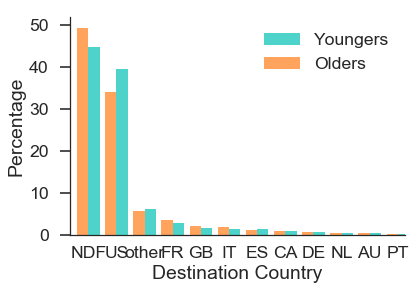

In [96]:
age = 50
width = 0.4

younger = sum(train_users.loc[train_users['age'] < age, 'country_destination'].value_counts())
older = sum(train_users.loc[train_users['age'] > age, 'country_destination'].value_counts())

younger_destinations = train_users.loc[train_users['age'] < age, 'country_destination'].value_counts() / younger * 100
older_destinations = train_users.loc[train_users['age'] > age, 'country_destination'].value_counts() / older * 100

younger_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Youngers', rot=0)
older_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Olders', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
plt.savefig("agedestination.png")

sns.despine()
plt.show()

##### Sessions

The `sessions` table contains several entries for a subset of the users. Session data is available for approx. `63% of the users`. The top user has `more than 2700 sessions`.

Each session entry contains information on
- which action was taken (`action`)
- which type of action that is (`action_type`)
- a more detailed description of the action (`action_detail`) 
- the type of device that action was taken on (`device_type`)
- how many seconds have passed since the last action was taken (`secs_elapsed`)

In [24]:
# load session dataset
sessions = pd.read_csv(DATA_PATH / "sessions.csv")

In [25]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [26]:
sessions.shape

(10567737, 6)

In [27]:
sessions['user_id'].nunique()

135483

#### Prepare data for modeling

##### Add aggregated sessions data

In [28]:
# rename the user_id column to id and drop the rows with missing 
sessions = (sessions
            .rename({"user_id" : "id"}, axis="columns")
            .dropna(subset=["id"])
           )

**Devices used to access AirBnB**

In [29]:
# define the unique number of devices used by the users
sessions.device_type.nunique()

14

In [30]:
# reshape the data frame based on the device types and the number of time they have been used by a single user
sessions_device_type_count = (pd.DataFrame(sessions
                                             .groupby("id")
                                             .device_type
                                             .value_counts()
                                          )
                              .rename({"device_type" : "count_sessions_device"}, axis="columns")
                              .reset_index()
                              .pivot(index="id",
                                     columns="device_type",
                                     values="count_sessions_device")
                              .reset_index()
                              .fillna(-1)
                             )

In [31]:
sessions_device_type_count.shape

(135483, 15)

In [32]:
sessions_device_type_count.head()

device_type,id,-unknown-,Android App Unknown Phone/Tablet,Android Phone,Blackberry,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch
0,00023iyk9l,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,36.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0
1,0010k6l0om,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,63.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,001wyh0pz8,-1.0,90.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0028jgx1x1,30.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,002qnbzfs5,14.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,775.0,-1.0


In [33]:
# a mapper to rename the columns in sessions_device_type_count dataframe
colname_mapper_devices = {c : f"count_device_{c.replace(' ', '_').lower()}"
                          for c in sessions_device_type_count.columns
                          if c != "id"}

In [34]:
# rename the column names in sessions_device_type_count dataframe
sessions_device_type_count.rename(colname_mapper_devices, axis="columns", inplace=True)

In [35]:
sessions_device_type_count.head()

device_type,id,count_device_-unknown-,count_device_android_app_unknown_phone/tablet,count_device_android_phone,count_device_blackberry,count_device_chromebook,count_device_linux_desktop,count_device_mac_desktop,count_device_opera_phone,count_device_tablet,count_device_windows_desktop,count_device_windows_phone,count_device_ipad_tablet,count_device_iphone,count_device_ipodtouch
0,00023iyk9l,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,36.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0
1,0010k6l0om,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,63.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,001wyh0pz8,-1.0,90.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0028jgx1x1,30.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,002qnbzfs5,14.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,775.0,-1.0


In [36]:
# define the prefered device for each user
sessions_preferred_device = (pd.DataFrame(sessions
                                             .groupby("id")
                                             .device_type
                                             .value_counts()
                                             .groupby(level=0)
                                             .head(1))
                             .rename({"device_type" : "to_drop"}, axis="columns")
                             .reset_index()
                             .rename({"device_type" : "preferred_device"}, axis="columns")
                             .drop("to_drop", axis="columns")
                            )

In [37]:
sessions_preferred_device.head()

,id,preferred_device
0,00023iyk9l,Mac Desktop
1,0010k6l0om,Mac Desktop
2,001wyh0pz8,Android App Unknown Phone/Tablet
3,0028jgx1x1,-unknown-
4,002qnbzfs5,iPhone


**Actions taken on AirBnB**

In [38]:
sessions.action.nunique()

359

There are many distinct values for "action", let's bin the long tail into a "other" category

In [39]:
def add_others(df_in, make_others, k=50):
    df = df_in.copy()
    for col in make_others:
        cnts = df[col].value_counts()
        df.loc[df.loc[:, col].isin(list(cnts.iloc[k-1:].index)), col] = "Other"
        
    return df

In [40]:
sessions = add_others(sessions, ["action"])

In [41]:
sessions.head(20)

,id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [42]:
sessions_action_count = (pd.DataFrame(sessions
                                             .groupby("id")
                                             .action
                                             .value_counts()
                                          )
                              .rename({"action" : "count_sessions_action"}, axis="columns")
                              .reset_index()
                              .pivot(index="id",
                                     columns="action",
                                     values="count_sessions_action")
                              .reset_index()
                              .fillna(-1)
                             )

In [43]:
colname_mapper_actions = {c : f"count_action_{c.replace(' ', '_').lower()}"
                          for c in sessions_action_count.columns
                          if c != "id"}

In [44]:
sessions_action_count.rename(colname_mapper_actions, axis="columns", inplace=True)

**Summary statistics of time elapsed, i.e. time spent in interaction with AirBnB**

In [45]:
sessions_agg_elapsed = (pd.DataFrame(sessions
                                          .groupby("id")
                                          .secs_elapsed
                                          .agg(["min", "median", "max"]))
                         .reset_index()
                       )

In [46]:
colname_mapper_secs_elapsed = {c : f"{c}_secs_elapsed"
                               for c in sessions_agg_elapsed.columns
                               if c != "id"}

In [47]:
sessions_agg_elapsed.rename(colname_mapper_secs_elapsed, axis="columns", inplace=True)

**Combine all sessions features into a single dataframe and merge with train data**

In [48]:
sessions_features = (sessions_agg_elapsed
                     .merge(sessions_action_count, how="outer", on="id")
                     .merge(sessions_device_type_count, how="outer", on="id")
                     .merge(sessions_preferred_device, how="outer", on="id")
                    )

Gather feature names to fill NAs later on

In [49]:
session_action_count_features = list(colname_mapper_actions.values())
session_agg_elapsed_features = list(colname_mapper_secs_elapsed.values())
session_count_device_features = list(colname_mapper_devices.values())

In [50]:
train_users_sessions = pd.merge(train_users,
                                sessions_features,
                                how="left",
                                on="id")

In [51]:
train_users.shape, train_users_sessions.shape

((213451, 16), (213451, 84))

#### Save intermediate result

In [52]:
DATA_OUTPUT_PATH = Path.cwd() / "output"

if not DATA_OUTPUT_PATH.is_dir():
    DATA_OUTPUT_PATH.mkdir()
    
train_users_sessions.to_pickle(DATA_OUTPUT_PATH / "train_users_sessions.pkl")

### Modeling

#### Read in data

In [53]:
DATA_OUTPUT_PATH = Path.cwd() / "output"

In [54]:
train_users_sessions = pd.read_pickle(DATA_OUTPUT_PATH / "train_users_sessions.pkl")

In [55]:
df = (train_users_sessions
      .set_index("id")
      .sort_values(by="date_account_created")
      .drop(["date_account_created", "date_first_booking"], axis=1))

In [56]:
df.head(10)

,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,count_device_linux_desktop,count_device_mac_desktop,count_device_opera_phone,count_device_tablet,count_device_windows_desktop,count_device_windows_phone,count_device_ipad_tablet,count_device_iphone,count_device_ipodtouch,preferred_device
id,,,,,,,,,,,,,,,,,,,,,
osr2jwljor,20100101215619,-unknown-,NaN,basic,0,en,other,other,omg,Web,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lsw9q7uk0j,20100102012558,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0d01nltbrs,20100103191905,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6uh8zyj2gn,20100104023758,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a1vcnhxeij,20100104004211,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yuuqmid2rp,20100104194251,FEMALE,36.0,basic,0,en,other,craigslist,untracked,Web,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dy3rgx56cu,20100105083259,FEMALE,37.0,basic,0,en,other,craigslist,linked,Web,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
om1ss59ys8,20100105051812,FEMALE,47.0,basic,0,en,other,craigslist,untracked,Web,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k6np330cm1,20100105060859,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df.shape

(213451, 81)

In [58]:
df.isna().sum()

timestamp_first_active                                0
gender                                                0
age                                               87990
signup_method                                         0
signup_flow                                           0
language                                              0
affiliate_channel                                     0
affiliate_provider                                    0
first_affiliate_tracked                            6065
signup_app                                            0
first_device_type                                     0
first_browser                                         0
country_destination                                   0
min_secs_elapsed                                 140820
median_secs_elapsed                              140820
max_secs_elapsed                                 140820
count_action_other                               140045
count_action_active                             

**Fill NAs**

In [59]:
df.age = df.age.fillna(-1)
df.first_affiliate_tracked = df.age.fillna("unknown")
df.preferred_device = df.preferred_device.fillna("unknown")

In [60]:
session_numerics_to_fill = session_action_count_features \
                            + session_agg_elapsed_features \
                            + session_count_device_features

df[session_numerics_to_fill] = df[session_numerics_to_fill].fillna(-1)

In [61]:
df, cats = make_categorical(df)

In [62]:
n_train = int(.7 * df.shape[0])
X = df.drop("country_destination", axis=1).copy()
y = df["country_destination"].copy()

X_train = X[:n_train]
y_train = y[:n_train]

X_valid = X[n_train:]
y_valid = y[n_train:]

In [63]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((149415, 80), (149415,), (64036, 80), (64036,))

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
m = RandomForestClassifier(n_estimators=50,
                           min_samples_leaf=3,
                           n_jobs=-1,
                           random_state=42)

In [66]:
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [67]:
m.score(X_valid, y_valid)

0.6906271472296833

In [68]:
preds_train_wd = format_preds_wd(m, X_train)
preds_valid_wd = format_preds_wd(m, X_valid)

In [69]:
scores_train = score_predictions_wd(preds_train_wd, y_train)

Average NDCG at 5: 0.8625


In [70]:
scores_valid = score_predictions_wd(preds_valid_wd, y_valid)

Average NDCG at 5: 0.8472


#### Archive

In [71]:
#import xgboost

In [72]:
#gbm = GradientBoostingClassifier(n_estimators=50,random_state=42)

In [73]:
#rf = RandomForestClassifier(n_estimators=50,
                           #min_samples_leaf=3,
                           #n_jobs=-1,
                           #random_state=42)

In [74]:
#from xgboost.sklearn import XGBClassifier

In [75]:
#xgb = XGBClassifier(n_estimators=50)

In [76]:
#xgb.fit(X_train, y_train)

In [77]:
#rf.fit(X_train, y_train)

In [78]:
#xgb.score(X_valid, y_valid)

In [79]:
#m.score(X_valid, y_valid)

In [80]:
#preds_train_wd = format_preds_wd(xgb, X_train)
#preds_valid_wd = format_preds_wd(xgb, X_valid)

In [81]:
#scores_train = score_predictions_wd(preds_train_wd, y_train)

In [82]:
#scores_valid = score_predictions_wd(preds_valid_wd, y_valid)

In [83]:
#preds_xgb = xgb.predict_proba(X_train)
#preds_rf = rf.predict_proba(X_train)

In [84]:
#preds_xgb[1:10]

In [85]:
#preds_concat = np.hstack((preds_xgb, preds_rf))

In [86]:
#preds_xgb.shape, preds_rf.shape, preds_concat.shape

In [87]:
#gbm = GradientBoostingClassifier(n_estimators=50,random_state=42)

In [88]:
#gbm.fit(preds_concat, y_train)

### Interpretation

#### Visualize feature importance

In [89]:
feat_importance = pd.DataFrame({"features": X_train.columns, 
                              "importance": m.feature_importances_}).sort_values("importance", ascending=False)

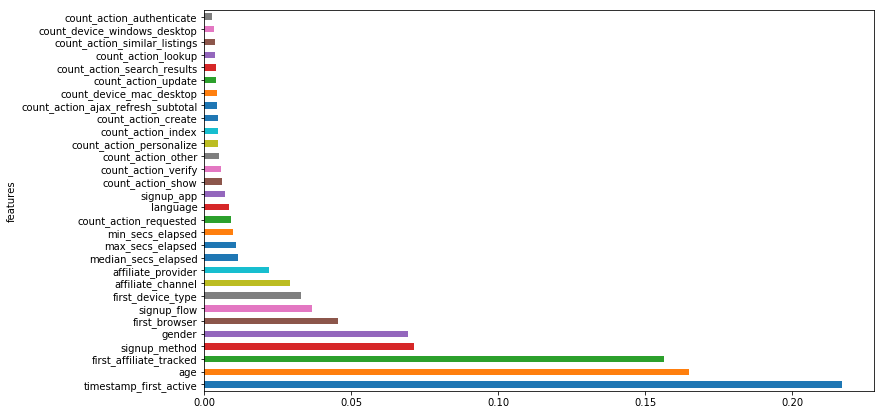

In [90]:
plot = feat_importance.iloc[:30].plot('features', 'importance', 'barh', figsize=(12,7), legend=False)
fig = plot.get_figure()
fig.savefig("output.png")

In [91]:
#rem_feat = list(feat_importance[feat_importance.importance> 0.01].features)+['country_destination']

#### Use learnings to optimize model

In [92]:
#df = df[rem_feat]

In [93]:
#df.shape

In [94]:
'''
n_train = int(.7 * df.shape[0])
X = df.drop("country_destination", axis=1).copy()
y = df["country_destination"].copy()

X_train = X[:n_train]
y_train = y[:n_train]

X_valid = X[n_train:]
y_valid = y[n_train:]
'''

'\nn_train = int(.7 * df.shape[0])\nX = df.drop("country_destination", axis=1).copy()\ny = df["country_destination"].copy()\n\nX_train = X[:n_train]\ny_train = y[:n_train]\n\nX_valid = X[n_train:]\ny_valid = y[n_train:]\n'

In [95]:
#X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

In [96]:
'''
m = RandomForestClassifier(n_estimators=50,
                           min_samples_leaf=3,
                           n_jobs=-1,
                           random_state=42)
'''

'\nm = RandomForestClassifier(n_estimators=50,\n                           min_samples_leaf=3,\n                           n_jobs=-1,\n                           random_state=42)\n'

In [97]:
#m.fit(X_train, y_train)

In [98]:
#m.score(X_valid, y_valid)

In [99]:
#preds_train_wd = format_preds_wd(m, X_train)
#preds_valid_wd = format_preds_wd(m, X_valid)

In [100]:
#scores_train = score_predictions_wd(preds_train_wd, y_train)

In [101]:
#scores_valid = score_predictions_wd(preds_valid_wd, y_valid)

### Final model

#### Load and transform test data

In [102]:
test_users = pd.read_csv(DATA_PATH / "test_users.csv")

In [103]:
test_users.shape

(62096, 15)

In [104]:
test_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [105]:
print(test_users.age[test_users.age<18].count())
print(test_users.age[test_users.age>90].count())
print(test_users.age.isna().sum())

30
385
28876


In [106]:
test_users = pd.merge(test_users, sessions_features, how="left", on="id")

In [107]:
test_users.sort_values(by= 'timestamp_first_active', ascending=False).head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,count_device_linux_desktop,count_device_mac_desktop,count_device_opera_phone,count_device_tablet,count_device_windows_desktop,count_device_windows_phone,count_device_ipad_tablet,count_device_iphone,count_device_ipodtouch,preferred_device
62095,9uqfg8txu3,2014-09-30,20140930235901,NaN,FEMALE,49.0,basic,0,en,other,...,-1.0,-1.0,-1.0,-1.0,14.0,-1.0,-1.0,-1.0,-1.0,Windows Desktop
62094,87k0fy4ugm,2014-09-30,20140930235430,NaN,-unknown-,NaN,basic,0,en,sem-brand,...,-1.0,11.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,Mac Desktop
62093,fa6260ziny,2014-09-30,20140930235408,NaN,-unknown-,NaN,basic,0,de,direct,...,-1.0,-1.0,-1.0,-1.0,78.0,-1.0,-1.0,-1.0,-1.0,Windows Desktop
62092,zp8xfonng8,2014-09-30,20140930235306,NaN,-unknown-,NaN,basic,23,ko,direct,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Android Phone
62091,cv0na2lf5a,2014-09-30,20140930235232,NaN,-unknown-,31.0,basic,0,en,direct,...,-1.0,-1.0,-1.0,-1.0,89.0,-1.0,-1.0,4.0,-1.0,Windows Desktop


In [108]:
test_users.id.count()

62096

In [109]:
s1= test_users.id
s2= sessions_device_type_count.id
s3= train_users.id
print(len(pd.Series(np.intersect1d(s1,s2))))
print(len(pd.Series(np.intersect1d(s1,s3))))
print(len(pd.Series(np.intersect1d(s2,s3))))

61668
0
73815


In [110]:
test_df = test_users.drop(["date_account_created", "date_first_booking"], axis=1)
test_df = test_df.set_index("id")

In [111]:
test_df.age = test_df.age.fillna(-1)
test_df.first_affiliate_tracked = test_df.age.fillna("unknown")
test_df.preferred_device = test_df.preferred_device.fillna("unknown")
test_df[session_numerics_to_fill] = test_df[session_numerics_to_fill].fillna(-1)

In [112]:
apply_categories(test_df, categories=cats)

In [113]:
test_df.head()

,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,count_device_linux_desktop,count_device_mac_desktop,count_device_opera_phone,count_device_tablet,count_device_windows_desktop,count_device_windows_phone,count_device_ipad_tablet,count_device_iphone,count_device_ipodtouch,preferred_device
id,,,,,,,,,,,,,,,,,,,,,
5uwns89zht,20140701000006,-1,35.0,-1,0,-1,-1,-1,35.0,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1
jtl0dijy2j,20140701000051,-1,-1.0,-1,0,-1,-1,-1,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9.0,-1.0,-1
xx0ulgorjt,20140701000148,-1,-1.0,-1,0,-1,-1,-1,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,58.0,-1.0,-1.0,-1.0,-1.0,-1
6c6puo6ix0,20140701000215,-1,-1.0,-1,0,-1,-1,-1,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,11.0,-1.0,-1.0,-1.0,-1.0,-1
czqhjk3yfe,20140701000305,-1,-1.0,-1,0,-1,-1,-1,-1.0,-1,...,-1.0,19.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1


#### Make predictions and save for submission

In [114]:
mapper_country_destination = {i : c for i, c in enumerate(cats["country_destination"])}

In [115]:
test_preds = format_preds_lng(m, test_df, mapper=mapper_country_destination)

In [116]:
test_preds.head(10)

,id,country
25245,0010k6l0om,NDF
87341,0010k6l0om,US
149437,0010k6l0om,other
211533,0010k6l0om,FR
273629,0010k6l0om,ES
55494,0031awlkjq,NDF
117590,0031awlkjq,US
179686,0031awlkjq,other
241782,0031awlkjq,ES
303878,0031awlkjq,FR


In [120]:
OUTPUT_PATH = Path.cwd() / "submission"

if not OUTPUT_PATH.is_dir():
    OUTPUT_PATH.mkdir()

In [121]:
SUBMISSION_NAME = "sub_data_festival01.csv"

In [122]:
test_preds.to_csv(OUTPUT_PATH / SUBMISSION_NAME, index=False)